<ipython-input-2-094c066b99b0>:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  feature_names = pd.read_csv('features.txt', delim_whitespace=True, header=None)[1].tolist()
<ipython-input-2-094c066b99b0>:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('X_train.txt', delim_whitespace=True, header=None, names=feature_names)
<ipython-input-2-094c066b99b0>:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv('y_train.txt', delim_whitespace=True, header=None, names=['Activity'])
<ipython-input-2-094c066b99b0>:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_tes

Top 100 Selected Features:
['tGravityAcc-mean()-X', 'tGravityAcc-max()-X', 'tGravityAcc-mean()-Y', 'angle(X,gravityMean)', 'angle(Y,gravityMean)', 'tGravityAcc-energy()-X', 'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-max()-Y', 'tGravityAcc-energy()-Y', 'tBodyAccJerk-std()-X', 'angle(Z,gravityMean)', 'tGravityAcc-arCoeff()-Z,2', 'fBodyAccMag-energy()', 'fBodyAccJerk-bandsEnergy()-1,16', 'fBodyAcc-mean()-X', 'fBodyAccJerk-bandsEnergy()-1,16_1', 'fBodyAccJerk-max()-X', 'tBodyAccMag-std()', 'tGravityAcc-energy()-Z', 'tGravityAccMag-std()', 'tGravityAcc-mean()-Z', 'tGravityAcc-min()-Z', 'fBodyAccMag-mad()', 'tGravityAcc-arCoeff()-Z,1', 'fBodyAccJerk-energy()-X', 'fBodyAccJerk-bandsEnergy()-1,24', 'tBodyAccJerkMag-energy()', 'fBodyAcc-entropy()-X', 'tGravityAcc-entropy()-Y', 'tBodyAccJerk-sma()', 'tBodyGyroJerk-iqr()-Z', 'fBodyAcc-bandsEnergy()-1,24', 'fBodyAcc-mad()-X', 'tBodyAcc-correlation()-X,Y', 'tGravityAcc-arCoeff()-Y,1', 'tGravityAcc-arCoeff()-X,2', 'fBodyAccJerk-mean(

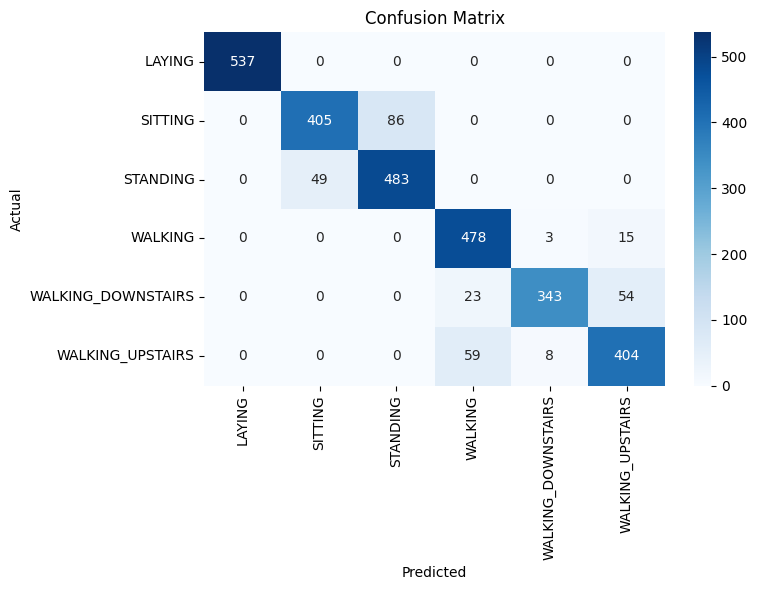

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
def load_data():
    # Load feature names
    feature_names = pd.read_csv('features.txt', delim_whitespace=True, header=None)[1].tolist()

    # Ensure unique feature names
    def make_unique(columns):
        counts = {}
        for i, col in enumerate(columns):
            if col in counts:
                counts[col] += 1
                columns[i] = f"{col}_{counts[col]}"
            else:
                counts[col] = 0
        return columns

    feature_names = make_unique(feature_names)

    # Load training data
    X_train = pd.read_csv('X_train.txt', delim_whitespace=True, header=None, names=feature_names)
    y_train = pd.read_csv('y_train.txt', delim_whitespace=True, header=None, names=['Activity'])

    # Load test data
    X_test = pd.read_csv('X_test.txt', delim_whitespace=True, header=None, names=feature_names)
    y_test = pd.read_csv('y_test.txt', delim_whitespace=True, header=None, names=['Activity'])

    return X_train, X_test, y_train, y_test

# Preprocess and feature selection
def preprocess_and_select_features(X_train, X_test, y_train, y_test, k=30):
    # Map activity labels
    activity_labels = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS',
                       4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}
    y_train['Activity'] = y_train['Activity'].map(activity_labels)
    y_test['Activity'] = y_test['Activity'].map(activity_labels)

    # Train Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train.values.ravel())

    # Select top k features
    importances = rf.feature_importances_
    top_indices = np.argsort(importances)[::-1][:k]
    top_feature_names = X_train.columns[top_indices]

    # Reduce the datasets
    X_train_selected = X_train[top_feature_names]
    X_test_selected = X_test[top_feature_names]

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    return X_train_scaled, X_test_scaled, y_train, y_test, top_feature_names

# Train model with hyperparameter tuning
def train_model(X_train, y_train):
    model = RandomForestClassifier(random_state=42)
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train.values.ravel())
    return grid_search.best_estimator_

# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Main
if __name__ == '__main__':
    # Step 1: Load data
    X_train, X_test, y_train, y_test = load_data()

    # Step 2: Preprocess + feature selection (top 100)
    X_train_sel, X_test_sel, y_train, y_test, feature_names = preprocess_and_select_features(X_train, X_test, y_train, y_test, k=100)

    print("Top 100 Selected Features:")
    print(feature_names.tolist())

    # Step 3: Train model
    model = train_model(X_train_sel, y_train)

    # Step 4: Predict & Evaluate
    y_pred = model.predict(X_test_sel)
    print("\n Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Step 5: Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
